# Preparation

<b>Load Libraries</b>

In [1]:
# general
import os, sys
cwd = os.getcwd()
os.chdir('..')
path_to_src = os.getcwd()
if path_to_src not in sys.path:
    sys.path.append(path_to_src)
os.chdir(cwd)
##
from src.jupyter.support import *
## visualization 
import statsmodels.api as sm
import squarify
## settings
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 10)
sns.set_theme('notebook')

# others
from warnings import simplefilter

<b>Load Dataset</b>

In [2]:
# dataset
df_base = pd.read_csv('../resource/data/raw.csv')

In [3]:
# clone
df_cleaned = df_base.copy()

<b>UDF</b>

In [4]:
# hist 
def plot_hist(ax, name: str):
    g = sns.histplot(df_cleaned[name], kde=True, ax=ax)
    g.set_ylabel(None)
    g.axes.lines[0].set_color('r')
    ##
    avg, med = df_cleaned[name].mean(), df_cleaned[name].median()
    g.axvline(avg, linestyle='--', color='black'); g.axvline(med, linestyle='--', color='black')
    ##
    _, ylim = g.get_ylim()
    if avg < med:
        xytext_avg = (avg*0.7, ylim*0.5)
        xytext_med = (med*1.25, ylim*0.4)
    else:
        xytext_avg = (avg*1.25, ylim*0.5)
        xytext_med = (med*0.7, ylim*0.4)
    """
    xy: head of arrow, xytext: tail of arrow
    """
    g.annotate('mean', xy=(avg, ylim*0.75), xytext=xytext_avg, 
               arrowprops=dict(arrowstyle='->', color='black', linewidth=2.5))
    g.annotate('median', xy=(med, ylim*0.75), xytext=xytext_med, 
               arrowprops=dict(arrowstyle='->', color='black', linewidth=2.5))
    
# boxen
def plot_boxen(ax, name: str):
    g = sns.boxenplot(df_cleaned[name], orient='h', ax=ax)

# qq
def plot_qq(ax, name: str):
    g = sm.qqplot(df_cleaned[name], line='r', ax=ax)

# tree map
def plot_treemap(ax, name: str):
    data_to_plot = df_cleaned[name].value_counts()
    labels, sizes = data_to_plot.index.to_numpy(), data_to_plot.values
    labels = [f'{label}\n({size})' for label, size in zip(labels, sizes)]

    g = squarify.plot(sizes, label=labels, color=sns.husl_palette(n_colors=len(labels)), 
                      ax=ax)
    g.set_title(name, 
                fontdict=dict(size=15, weight='bold'))

In [5]:
# hexbin 
def pair_grid_upper(x, y, color, **kwargs):
    cmap = sns.light_palette(color, as_cmap=True)
    plt.hexbin(x, y, gridsize=15, cmap=cmap, **kwargs)

# scatter plot
def pair_grid_lower(x, y, **kwargs):
    ax = plt.gca()
    g = sns.regplot(x=x, y=y, ax=ax, scatter_kws=dict(facecolor='none'), **kwargs)
    g.axes.lines[0].set_color('r')

<b>MLflow</b>

In [6]:
# connect to local server
## tracking uri
mlflow.set_tracking_uri('http://127.0.0.1:5000/')
## experiment
experiment_name = 'Feature engineering'
try:
    mlflow.create_experiment(name=experiment_name, artifact_location='resource/mlflow/runs')
except:
    mlflow.set_experiment(experiment_name=experiment_name)

# 1. Data Wrangling

<b>General</b>

In [7]:
# shape
df_base.shape

(10000, 14)

In [8]:
# head
df_base.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [9]:
# tail
df_base.tail()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1
9999,10000,15628319,Walker,792,France,Female,28,4,130142.79,1,1,0,38190.78,0


In [10]:
# info
df_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [11]:
# dropping irrelavant columns
try:
    df_cleaned.drop(['RowNumber', 'CustomerId', 'Surname'], 
                    inplace=True, axis=1)
except:
    print('Check columns\'s names again!')

In [12]:
# re-format binary columns
names_to_reformat = df_cleaned.nunique().to_frame('nunique')\
    .query('nunique == 2').index.drop('Gender').tolist()
##
df_cleaned[names_to_reformat] = df_cleaned[names_to_reformat].map(lambda x: 'Yes' if x == 1 else 'No')

In [13]:
# stripping
##
df_cleaned.columns = [name.strip() for name in df_cleaned.columns.tolist()]
cat_cols = df_cleaned.select_dtypes('object').columns.tolist()
num_cols = df_cleaned.select_dtypes(np.number).columns.tolist()
##
df_cleaned[cat_cols] = df_cleaned[cat_cols].map(lambda x: x.strip())

In [14]:
# null strings
mask = df_cleaned[cat_cols] == ''
counts = mask.sum(axis=0)
print(f'Total null strings: \n{counts}')

Total null strings: 
Geography         0
Gender            0
HasCrCard         0
IsActiveMember    0
Exited            0
dtype: int64


In [15]:
# single-value columns
single_value_cols = df_cleaned.nunique().to_frame('nunique')\
    .query('nunique == 1').index.tolist()
print(f'Total single-value columns: \n{len(single_value_cols)}')

Total single-value columns: 
0


<b>Additional</b>

In [16]:
# missing values
mask = df_cleaned.isnull()
counts = mask.sum(axis=0)
print(f'Total missing values: \n{counts}')

Total missing values: 
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64


In [17]:
# duplications
mask = df_cleaned.duplicated()
counts = mask.sum()
print(f'Total duplications: \n{counts}')

Total duplications: 
0


<b>Finalize</b>

In [18]:
df_cleaned.to_csv('../resource/data/cleaned.csv', index=False)

# 2.1 EDA (General)

<b>Univariate Analysis</b>

In [20]:
# summarize statistics
df_cleaned[num_cols].describe([0.01, 0.25, 0.5, 0.75, 0.99]).T

,count,mean,std,min,1%,25%,50%,75%,99%,max
CreditScore,10000.0,650.528800,96.653299,350.00,432.0000,584.00,652.000,718.0000,850.0000,850.00
Age,10000.0,38.921800,10.487806,18.00,21.0000,32.00,37.000,44.0000,72.0000,92.00
Tenure,10000.0,5.012800,2.892174,0.00,0.0000,3.00,5.000,7.0000,10.0000,10.00
Balance,10000.0,76485.889288,62397.405202,0.00,0.0000,0.00,97198.540,127644.2400,185967.9854,250898.09
NumOfProducts,10000.0,1.530200,0.581654,1.00,1.0000,1.00,1.000,2.0000,3.0000,4.00
EstimatedSalary,10000.0,100090.239881,57510.492818,11.58,1842.8253,51002.11,100193.915,149388.2475,198069.7345,199992.48


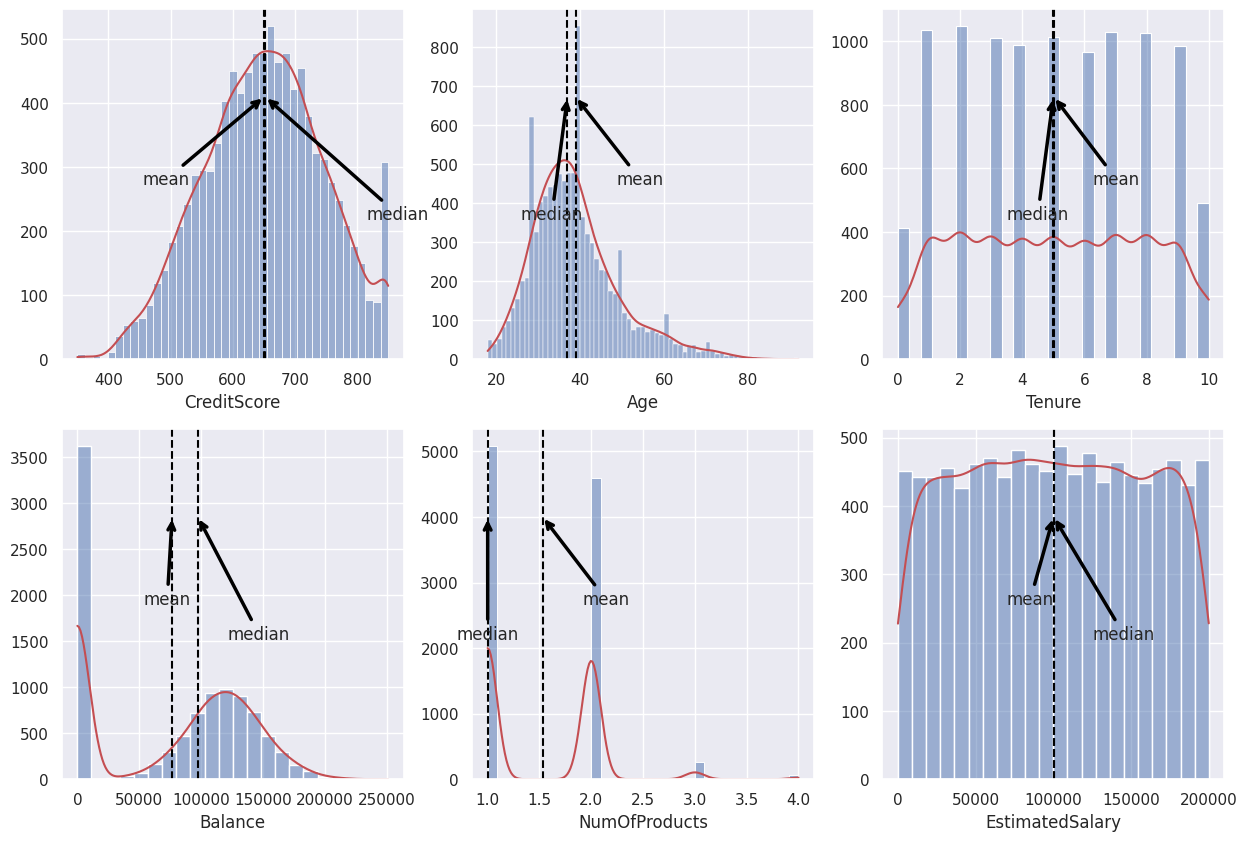

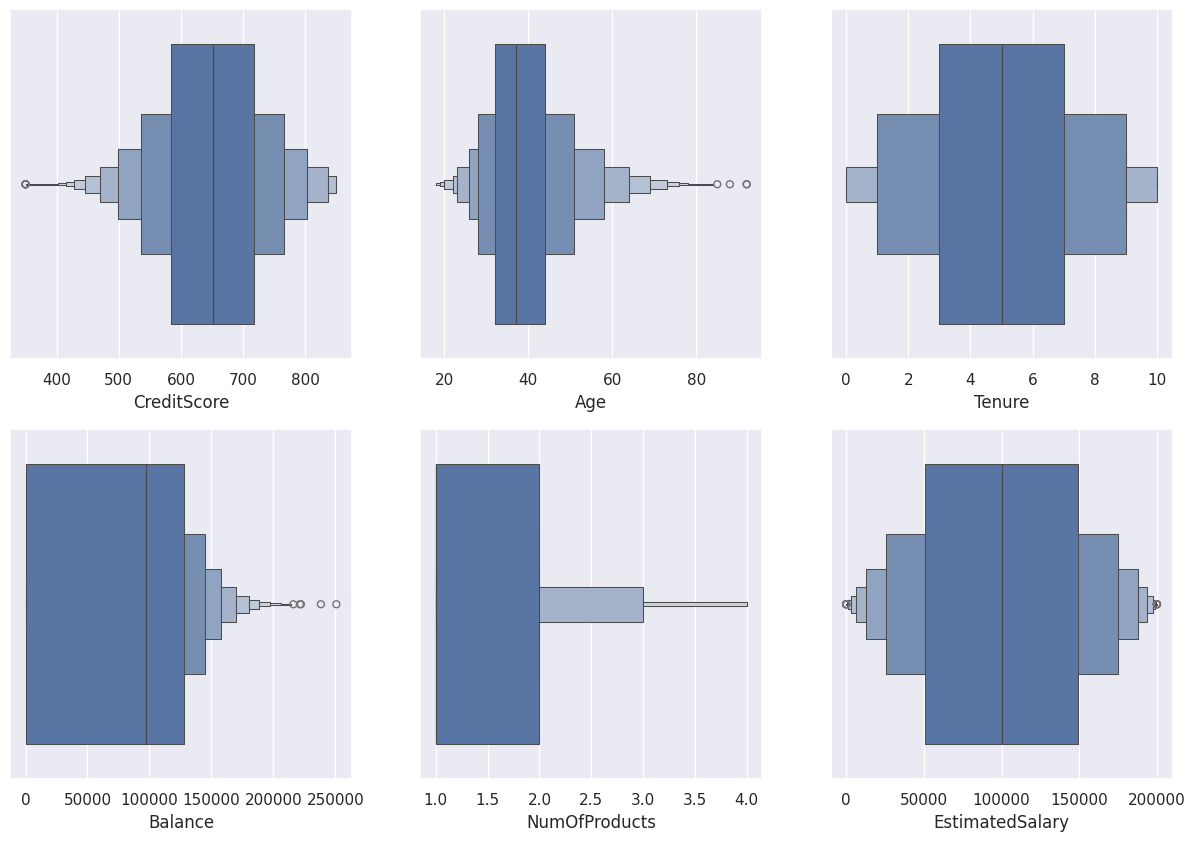

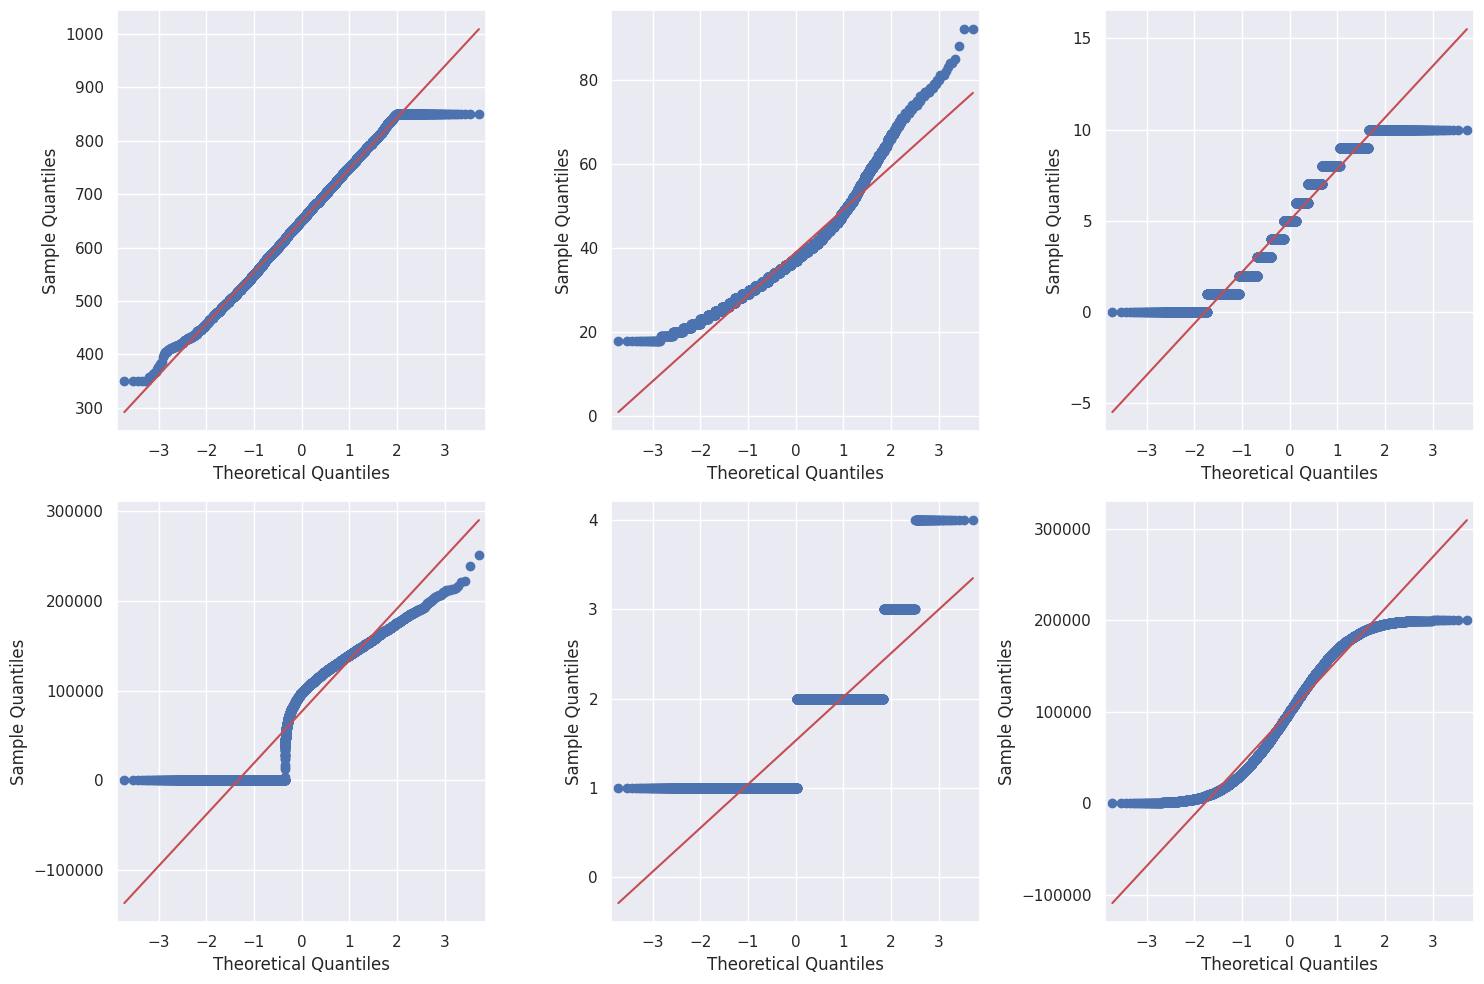

In [99]:
# hist + boxen + qq
##
figs, axes = dict(), dict()
graphs = ['hist', 'boxen', 'qq']
for graph in graphs:
    figs[graph], axes[graph] = plt.subplots(2, 3, sharex=False, sharey=False, 
                                            figsize=(15, 10))
##
names = np.array(num_cols).reshape(2, 3)
##
for i in range(2):
    for j in range(3):
        plot_hist(axes['hist'][i, j], names[i, j])
        plot_boxen(axes['boxen'][i, j], names[i, j])
        plot_qq(axes['qq'][i, j], names[i, j])

for name, fig in figs.items():
    fig.savefig(f'../resource/jupyter/image/eda_{name}.png')

plt.tight_layout()
plt.show()

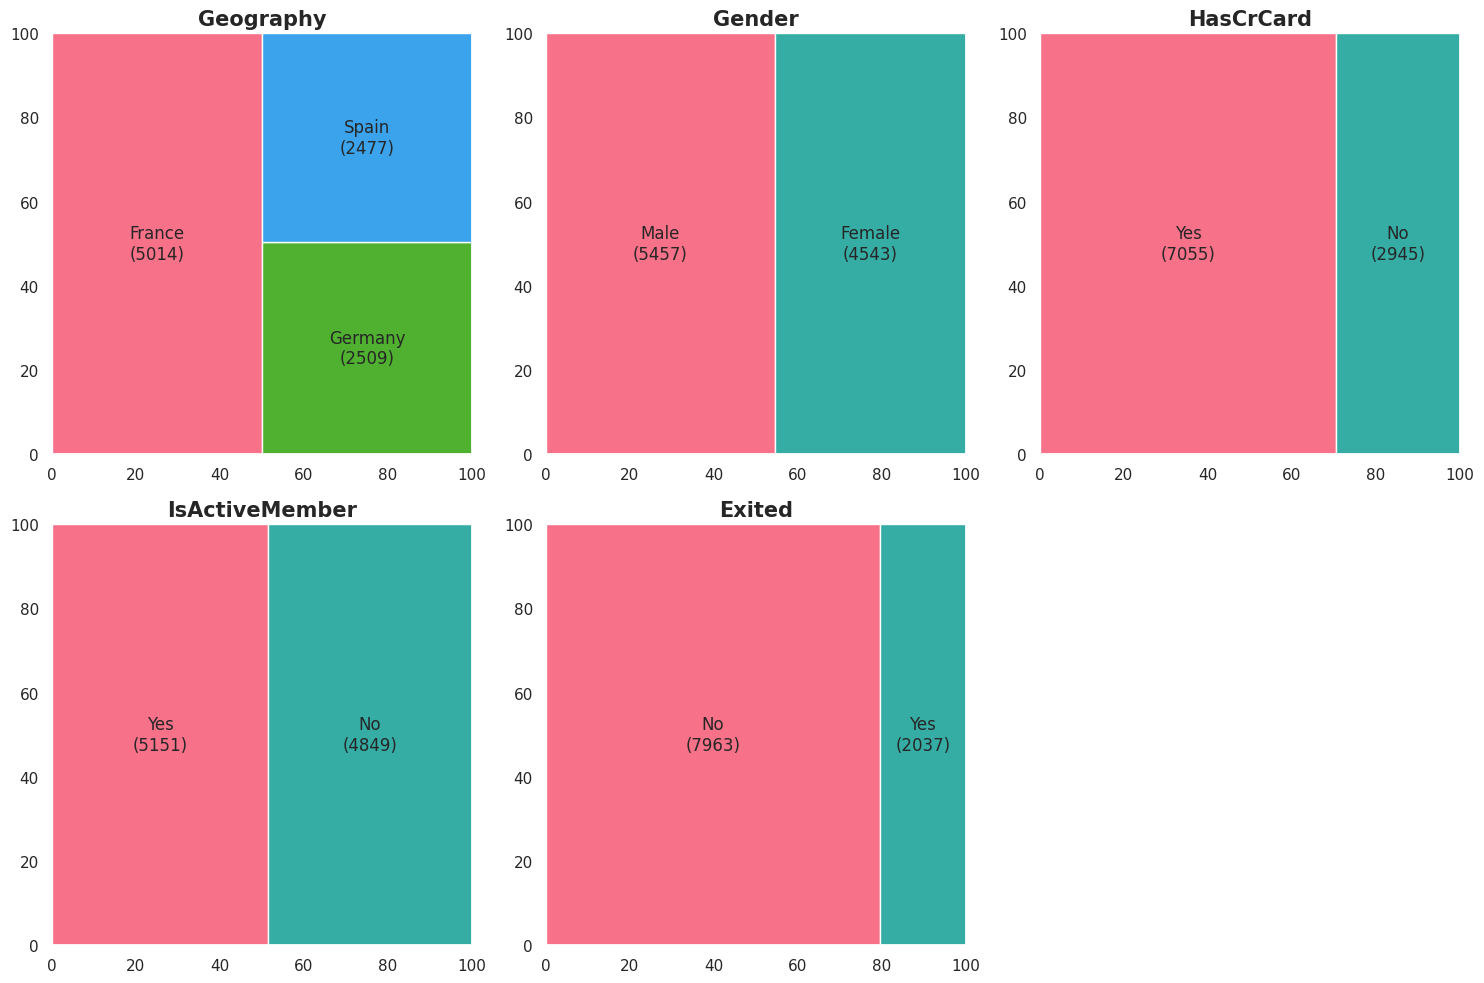

In [116]:
# summarize statistics
fig, axes = plt.subplots(2, 3, sharex=False, sharey=False, 
                         figsize=(15, 10))
names = cat_cols.copy()
names.append('0')
names = np.array(names).reshape(2, 3)

for i in range(2):
    for j in range(3):
        if names[i, j] != '0':
            plot_treemap(axes[i, j], names[i, j])
        else:
            axes[i, j].set_visible(False)

fig.savefig('../resource/jupyter/image/eda_treemap.png')

plt.tight_layout()
plt.show()

<b>Bivariate</b>

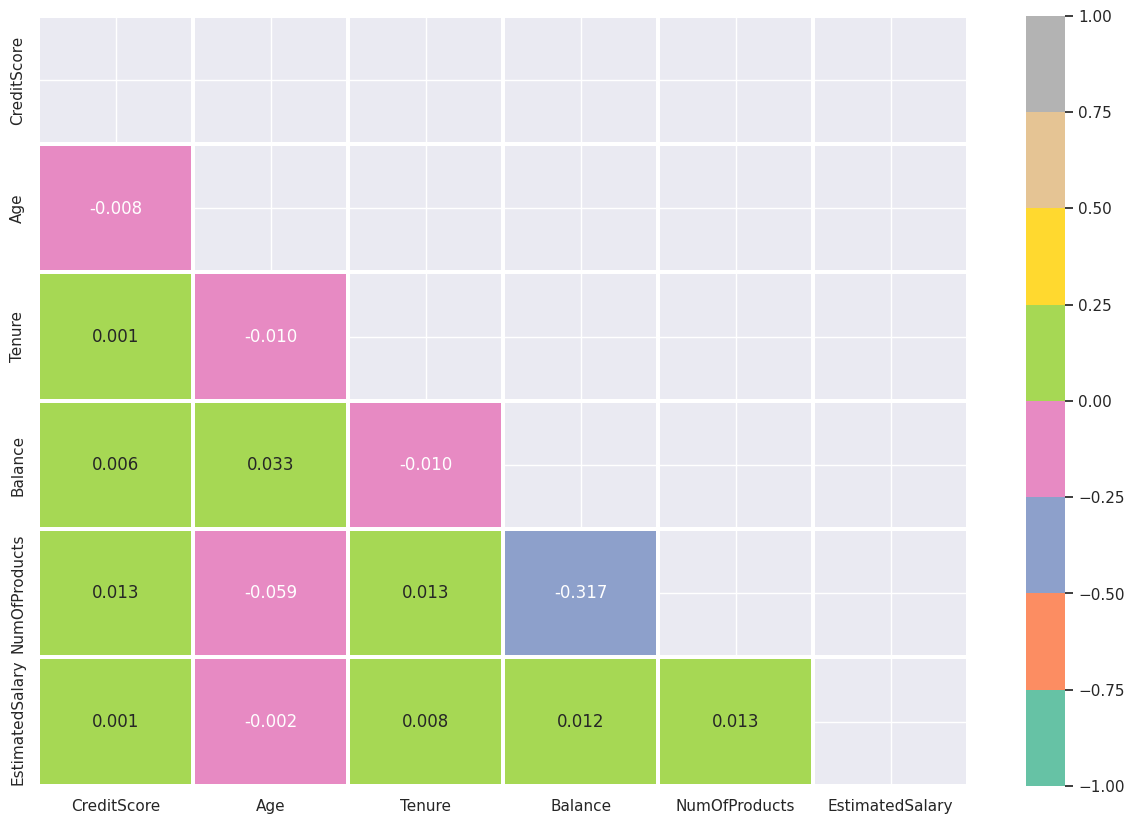

In [38]:
# correlation 
corr = df_cleaned[num_cols].corr(method='spearman')
##
i, num_iters = 1, len(num_cols)
while i < num_iters:
    for j in range(i):
        if corr.iloc[i, j] >= 0.5:
            print(f'{num_cols[i]} ~ {num_cols[j]}')

    i += 1
##
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, 
            annot=True, fmt='.3f',
            cmap='Set2', linewidths=1.5)
plt.show()

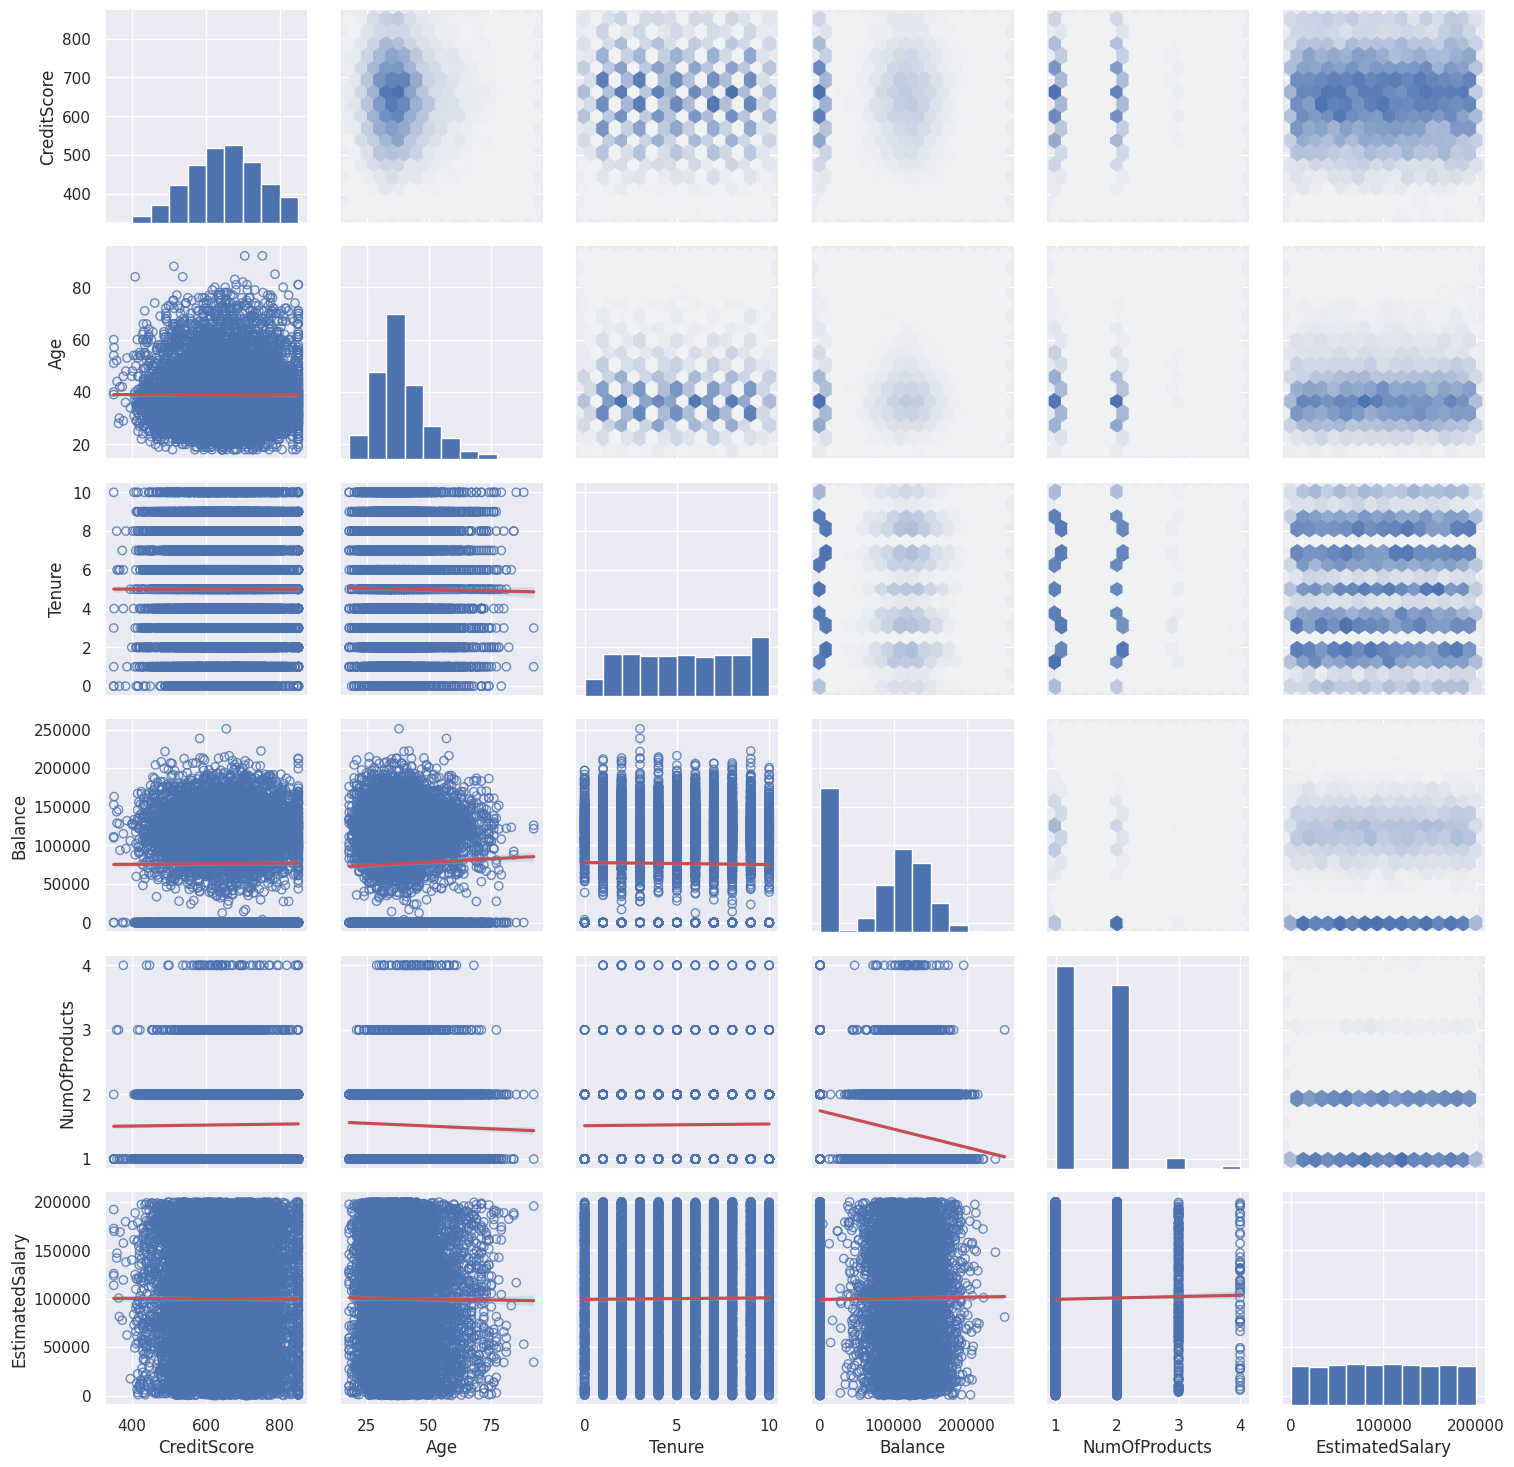

In [54]:
# pair plot
fig = sns.PairGrid(df_cleaned[num_cols])
fig.map_lower(pair_grid_lower)
fig.map_diag(plt.hist)
fig.map_upper(pair_grid_upper)
##
fig.savefig('../resource/jupyter/image/eda_pairplot.png')

plt.show()

# 2.2 EDA (Additional)

# 3. Baseline Evaluation

<b>Preparation</b>

In [19]:
# prepare data to train
materials = prepare_data_to_train('../resource/data/cleaned.csv')
##
num_idxes = [i for i, name in enumerate(df_cleaned.columns) if name in num_cols]
cat_idxes = [i for i, name in enumerate(df_cleaned.columns.drop('Exited')) if name in cat_cols]

<b>Baseline Evaluation</b>

In [32]:
# warnings
simplefilter(action='ignore')

# base models
base_models = load_base_models()

# transformers
ct = ColumnTransformer(transformers=[('cat_pro', OneHotEncoder(drop='first', sparse_output=False), cat_idxes)], 
                       remainder='passthrough')

# mlflow
results = dict()
for name, model in base_models:
    pipeline = Pipeline([('ct', ct), 
                         (name, model)])
    cv_results = cross_val_score(estimator=pipeline, X=materials['X_train'], y=materials['y_train'], 
                                 scoring=make_scorer(fbeta_score, beta=2), 
                                 cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3))
    print(f'{name}: {cv_results.mean()} ({cv_results.std()})')
    results[name] = cv_results
    ##
    pipeline.fit(materials['X_train'], materials['y_train'])
    val_predictions = pipeline.predict(materials['X_test'])
    val_fbeta = fbeta_score(materials['y_test'], val_predictions, 
                            beta=2)
    with mlflow.start_run():
        ###
        mlflow.set_tags({'pre_pro': 'ohe', 'base_model': name, 
                         'beta_f': 2})
        ###
        mlflow.log_metrics({'avg_fbeta': cv_results.mean(), 
                            'val_fbeta': val_fbeta})
        ###
        mlflow.sklearn.log_model(sk_model=pipeline, artifact_path='model')

LR: 0.10823117882615874 (0.05408762137187286)
KNN: 0.09150825564795226 (0.03002013005904666)
SVM: 0.0 (0.0)
CART: 0.5067577212473954 (0.03470357126746483)
ET: 0.4911352306296957 (0.03789841888857175)
RF: 0.5075016572325027 (0.044122059338040406)
GB: 0.5126864837474739 (0.03937171144284293)
LGBM: 0.5331990935030488 (0.03394591534188733)
XGB: 0.5277358676352644 (0.03775722098697611)


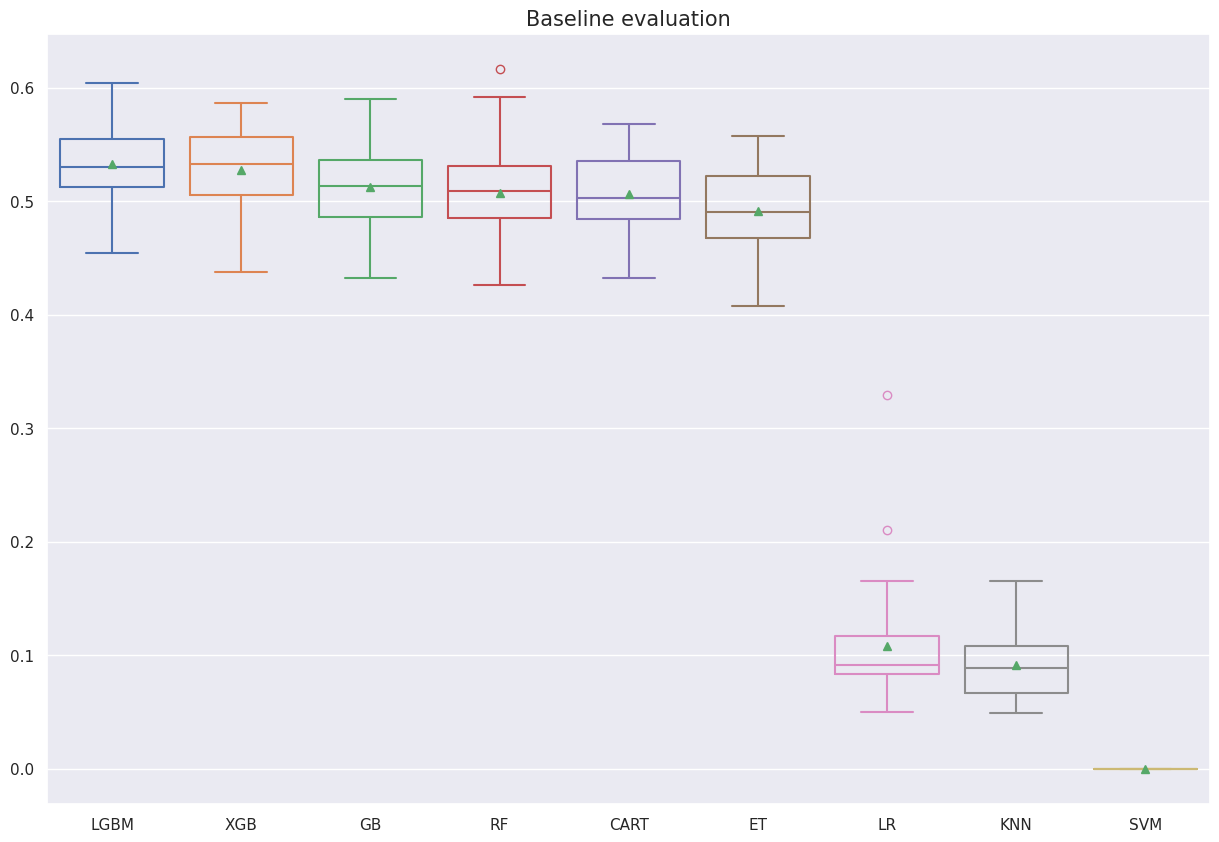

In [35]:
# plotting kfolds result
fig = plot_kfold_results(kfold_results=results, title='Baseline evaluation')
fig.savefig('../resource/jupyter/image/baseline_evaluation.png')

<b>Evaluation - Scaling</b>

In [24]:
# warnings
simplefilter(action='ignore')

# selected base models
selected_base_models = get_seleted_models(['LR', 'LGBM', 'RF'])

# scaling: standardization
ct = ColumnTransformer([('cat_pro', OneHotEncoder(drop='first', sparse_output=False), cat_idxes), 
                        ('num_pro', StandardScaler(), num_idxes)])

# evaluation
results = dict()
for name, model in selected_base_models:
    pipeline = Pipeline([('ct', ct), (name, model)])
    ##
    cv_results = cross_val_score(pipeline, materials['X_train'], materials['y_train'], 
                                 scoring=make_scorer(fbeta_score, beta=2), 
                                 cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3))
    print(f'{name}: {cv_results.mean()} ({cv_results.std()})')
    results[name] = cv_results
    ##
    pipeline.fit(materials['X_train'], materials['y_train'])
    val_predictions = pipeline.predict(materials['X_test'])
    val_fbeta = fbeta_score(materials['y_test'], val_predictions, 
                            beta=2)
    with mlflow.start_run():
        ###
        mlflow.set_tags({'pre_pro': 'std_ohe', 'base_model': name, 
                         'beta_f': 2})
        ###
        mlflow.log_metrics({'avg_fbeta': cv_results.mean(), 
                            'val_fbeta': val_fbeta})
        ###
        mlflow.sklearn.log_model(sk_model=pipeline, artifact_path='model')


LR: 0.2500272350258745 (0.030329745481991476)
RF: 0.5075051383189468 (0.045774412388308795)
LGBM: 0.5331469335426794 (0.03756506552256145)


In [25]:
# warnings
simplefilter(action='ignore')

# selected base models
selected_base_models = get_seleted_models(['LR', 'LGBM', 'RF'])

# scaling: power transformation
ct = ColumnTransformer([('cat_pro', OneHotEncoder(drop='first', sparse_output=False), cat_idxes), 
                        ('num_pro', PowerTransformer(method='yeo-johnson', standardize=True), num_idxes)])

# evaluation
results = dict()
for name, model in selected_base_models:
    pipeline = Pipeline([('ct', ct), (name, model)])
    ##
    cv_results = cross_val_score(pipeline, materials['X_train'], materials['y_train'], 
                                 scoring=make_scorer(fbeta_score, beta=2), 
                                 cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3))
    print(f'{name}: {cv_results.mean()} ({cv_results.std()})')
    results[name] = cv_results
    ##
    pipeline.fit(materials['X_train'], materials['y_train'])
    val_predictions = pipeline.predict(materials['X_test'])
    val_fbeta = fbeta_score(materials['y_test'], val_predictions, 
                            beta=2)
    with mlflow.start_run():
        ###
        mlflow.set_tags({'pre_pro': 'pwt_ohe', 'base_model': name, 
                         'beta_f': 2})
        ###
        mlflow.log_metrics({'avg_fbeta': cv_results.mean(), 
                            'val_fbeta': val_fbeta})
        ###
        mlflow.sklearn.log_model(sk_model=pipeline, artifact_path='model')

LR: 0.29579057477944054 (0.03198942207532616)
RF: 0.510187683653371 (0.0378817479077759)
LGBM: 0.5283276843360504 (0.03576984483469908)


In [26]:
# warnings
simplefilter(action='ignore')

# selected base models
selected_base_models = get_seleted_models(['LR', 'LGBM', 'RF'])

# scaling: quantile transformation
ct = ColumnTransformer([('cat_pro', OneHotEncoder(drop='first', sparse_output=False), cat_idxes), 
                        ('num_pro', QuantileTransformer(output_distribution='normal'), num_idxes)])

# evaluation
results = dict()
for name, model in selected_base_models:
    pipeline = Pipeline([('ct', ct), (name, model)])
    ##
    cv_results = cross_val_score(pipeline, materials['X_train'], materials['y_train'], 
                                 scoring=make_scorer(fbeta_score, beta=2), 
                                 cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3))
    print(f'{name}: {cv_results.mean()} ({cv_results.std()})')
    results[name] = cv_results
    ##
    pipeline.fit(materials['X_train'], materials['y_train'])
    val_predictions = pipeline.predict(materials['X_test'])
    val_fbeta = fbeta_score(materials['y_test'], val_predictions, 
                            beta=2)
    with mlflow.start_run():
        ###
        mlflow.set_tags({'pre_pro': 'qtt_ohe', 'base_model': name, 
                         'beta_f': 2})
        ###
        mlflow.log_metrics({'avg_fbeta': cv_results.mean(), 
                            'val_fbeta': val_fbeta})
        ###
        mlflow.sklearn.log_model(sk_model=pipeline, artifact_path='model')

LR: 0.2947260336059862 (0.03964676192051549)
RF: 0.5110992545346152 (0.043166731262043234)
LGBM: 0.5314392518072107 (0.03308922092881561)


<b>Evaluation - Resampling</b>

In [26]:
# warnings
simplefilter(action='ignore')

# base model: LR and RF
base_models = get_seleted_models(['LR', 'RF'])

# transformers
ct = ColumnTransformer(transformers=[('cat_pro', OneHotEncoder(drop='first', sparse_output=False), cat_idxes), 
                                     ('num_pro', QuantileTransformer(output_distribution='normal'), num_idxes)])

# evaluation: ROS
for name, model in base_models:
    pipeline = Pipeline([('ct', ct), ('ros', RandomOverSampler()), (name, model)])
    cv_results = cross_val_score(pipeline, materials['X_train'], materials['y_train'], 
                                scoring=make_scorer(fbeta_score, beta=2), 
                                cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3))
    print(f'{name}: {cv_results.mean()} ({cv_results.std()})')

    #
    pipeline.fit(materials['X_train'], materials['y_train'])
    val_predictions = pipeline.predict(materials['X_test'])
    val_fbeta = fbeta_score(materials['y_test'], val_predictions, 
                            beta=2)

    #
    with mlflow.start_run():
        ##
        mlflow.set_tags({'pre_pro': 'qtt_ohe_ros', 'base_model': name, 
                        'beta_f': 2})
        ##
        mlflow.log_metrics({'avg_fbeta': cv_results.mean(), 
                            'val_fbeta': val_fbeta})
        ##
        mlflow.sklearn.log_model(sk_model=pipeline, artifact_path='model')

LR: 0.6221962330254609 (0.03260699289268943)
RF: 0.5741708547163272 (0.03462877315398184)
